# Machine Learning - Decision Tree and Random Forest
In this project we are to design a DT to predict type of a movie (Movie or TV Show)

First reading the csv file

In [1]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df.head()

,type,title,cast,country,release_year,listed_in,description
0,Movie,Dick Johnson Is Dead,NaN,United States,2020,Documentaries,"As her father nears the end of his life, filmm..."
1,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,TV Show,Jailbirds New Orleans,NaN,NaN,2021,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          11059 non-null  object
 1   title         11059 non-null  object
 2   cast          9694 non-null   object
 3   country       8364 non-null   object
 4   release_year  11059 non-null  int64 
 5   listed_in     11059 non-null  object
 6   description   11059 non-null  object
dtypes: int64(1), object(6)
memory usage: 604.9+ KB


In [3]:
df.describe()

,release_year
count,11059.000000
mean,2014.209603
std,8.959517
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In cast and country columns we hanve some NaN 

In [4]:
for c in df.columns:
    p = df[c].isnull().sum()/df.shape[0] * 100
    print(f"{c}: {p:.2f} %")

type: 0.00 %
title: 0.00 %
cast: 12.34 %
country: 24.37 %
release_year: 0.00 %
listed_in: 0.00 %
description: 0.00 %


## Phase One: Preprocessing
* First for handling missing data some common ways are:
    1. Listwise Deletion
    2. Average Imputation
    3. Regression Substitution
    4. Common-Point Imputation

> In this problem for country i used `Common-Point Imputation` and for cast column i use `Listwise Deletion` 

* For Classified information we can use:  
    1. One Hot Encoding
    2. Label Encoding

> For the part with the bag of words i use One Hot Encoding (1/0) and for `genre1` and `genre2` i use Label Encoding.

* For handling `listed_in` column i brok that into two columns (As suggested), `genre1` and `genre2` 

In [5]:
df['country'].fillna(df['country'].mode()[0], inplace=True)
df.dropna(subset=['cast',],inplace=True)
df['genre1'] = None
df['genre2'] = None
for index, row in df.iterrows():
    l = row['listed_in'].split(',')
    df.at[index, 'genre1'] = l[0]
    if len(l) > 1:
        df.at[index, 'genre2'] = l[1]
df.head()

,type,title,cast,country,release_year,listed_in,description,genre1,genre2
1,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",International TV Shows,TV Dramas
2,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Crime TV Shows,International TV Shows
4,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,International TV Shows,Romantic TV Shows
5,TV Show,Midnight Mass,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",United States,2021,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,TV Dramas,TV Horror
6,Movie,My Little Pony: A New Generation,"Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",United States,2021,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,Children & Family Movies,None


### Extracting features from text
I used `TfidVectorizer` to count words of **title, description and casts** columns.  

Features:
* Top 50 words of `description`
* Top 20 words of `title`
* Top 20 words of `cast` (top 20 actors)  
* `genre1` and `genre2` (Label encoded)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
dsc_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                                 stop_words='english', max_features=50)
title_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1),
                                   stop_words='english', max_features=20)
cast_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2,2),
                                  stop_words='english', max_features=20)

dsc_vectorized = dsc_vectorizer.fit_transform(df['description'])
title_vectorized = title_vectorizer.fit_transform(df['title'])
cast_vectorized = cast_vectorizer.fit_transform(df['cast'])

In [7]:
dsc_features = pd.DataFrame(dsc_vectorized.toarray(),columns=dsc_vectorizer.get_feature_names_out())
title_features = pd.DataFrame(title_vectorized.toarray(),
                          columns=title_vectorizer.get_feature_names_out())
cast_features = pd.DataFrame(cast_vectorized.toarray(),
                             columns=cast_vectorizer.get_feature_names_out())

Now concatenating features and One Hot Encoded them

In [8]:
inputs = pd.concat([dsc_features, title_features, cast_features], axis=1)
inputs[inputs > 0] = 1
inputs

,best,city,comedy,daughter,day,death,documentary,family,father,finds,...,om puri,paresh rawal,rajesh kava,rukh khan,rupa bhimani,shah rukh,takahiro sakurai,tara strong,vincent tong,yuki kaji
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now add genre1 and genre2 and label encod them

In [9]:
from sklearn import preprocessing
le_genre1 = preprocessing.LabelEncoder()
le_genre2 = preprocessing.LabelEncoder()
inputs['genre1'] = le_genre1.fit_transform(df['genre1'])
inputs['genre2'] = le_genre2.fit_transform(df['genre2'])
inputs

,best,city,comedy,daughter,day,death,documentary,family,father,finds,...,rajesh kava,rukh khan,rupa bhimani,shah rukh,takahiro sakurai,tara strong,vincent tong,yuki kaji,genre1,genre2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,62
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,33
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,48
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62,63
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
9690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,13
9691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,12
9692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,12


## Phase Two: Prediction & Optimization
First encode type column and create `target` array  

In [10]:
le_type = preprocessing.LabelEncoder()
targets = le_type.fit_transform(df['type'])
targets

array([1, 1, 1, ..., 1, 1, 1])

Using `train_test_split` function to divide train and test  
I split data such that 70% for training and 30% for testing 

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=40)
print('train_len: ',X_train.shape[0],'\ntest_len:  ',X_test.shape[0])
# X_train.drop(['genre1', 'genre2'],axis=1, inplace=True)
# X_test.drop(['genre1', 'genre2'],axis=1, inplace=True)

train_len:  6785 
test_len:   2909


The accuracy is **99.6%**  
Basically it's because high correlation between genre and type of the movie

In [12]:
from sklearn import tree 
DT = tree.DecisionTreeClassifier(max_depth=10, criterion='entropy', min_samples_split=2)
DT.fit(X_train, y_train)
DT.score(X_test, y_test)

0.9962186318322448

Now spliting data, 98% for train

In [13]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.02, random_state=40)
DT2 = tree.DecisionTreeClassifier(max_depth=10, criterion='entropy', min_samples_split=2)
DT2.fit(X_train, y_train)
DT2.score(X_test, y_test)

0.9948453608247423

Now spliting, 40 to 60

In [14]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.6, random_state=40)
DT3 = tree.DecisionTreeClassifier(max_depth=10, criterion='entropy', min_samples_split=2)
DT3.fit(X_train, y_train)
DT3.score(X_test, y_test)

0.9960460718583463

> As we saw when we using 98% for the accuracy decreases  
It's because of **Overfitting**

### Confusion 

In [15]:
y_predicted = DT.predict(X_test)

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)

Text(69.0, 0.5, 'Truth')

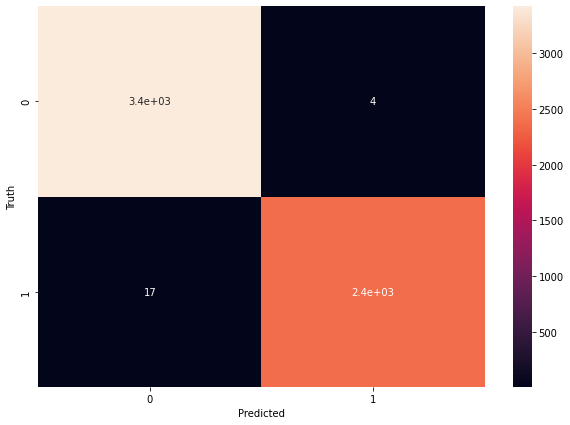

In [17]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### GridSearch CSV
Now using `GridSearchCV` function to find best `max_depth` and `min_samples_split` hyper parameter to get best output

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
gsc = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(),
        param_grid={
            'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
            'min_samples_split':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
        },
        error_score='raise')
grid_result = gsc.fit(X_train, y_train)
best_param = grid_result.best_params_

In [19]:
DT_best = tree.DecisionTreeClassifier(max_depth=best_param['max_depth'],
                                      min_samples_split=best_param['min_samples_split'])
DT_best.fit(X_train, y_train)
print('accuracy: ', DT_best.score(X_test, y_test))
best_param

accuracy:  0.9948427024239299


{'max_depth': 90, 'min_samples_split': 5}

checking effect of `max_depth` on accuracy  
* For this part i droped the genre to see the transition better

In [20]:
X_train.drop(['genre1', 'genre2'],axis=1, inplace=True)
X_test.drop(['genre1', 'genre2'],axis=1, inplace=True)

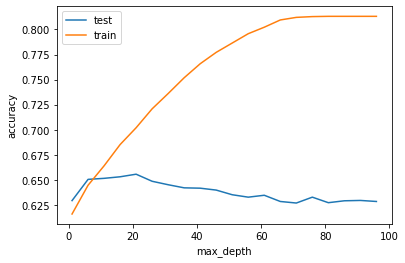

In [21]:
acc_test = []
acc_train = []
for i in range(1, 100, 5):
    dt = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy', min_samples_split=2)
    dt.fit(X_train, y_train)
    acc_test.append(dt.score(X_test, y_test))
    acc_train.append(dt.score(X_train, y_train))
plt.plot([i for i in range(1,100, 5)], acc_test)
plt.plot([i for i in range(1,100, 5)], acc_train )
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['test', 'train'])

With max_depth 20 and min_samples_split equal to 8 we get 100% percent accuracy

## Phase Three: Random Forest
Now checking Random Forest method  
two hyper parameter that i checked is `n_estimator` and `max_depth`:   

* `n_estimator`: number of trees in the forest
* `max_depth` : maximum depth of each tree

In [22]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=40)
RF = RandomForestClassifier(n_estimators=100, max_depth=30)
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=30)

chekcing `n_estimator` hyper parameter

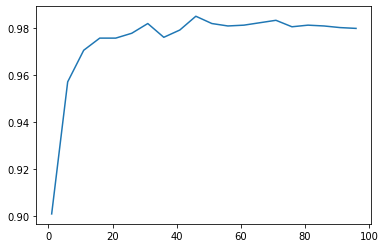

In [23]:
acc = []
for i in range(1, 100, 5):
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    acc.append(rf.score(X_test, y_test))
plt.plot([i for i in range(1, 100, 5)], acc)

checking `max_depth` changing

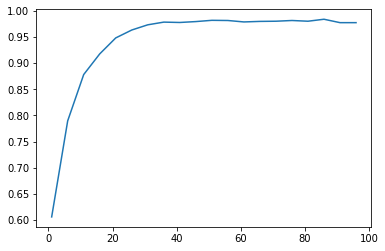

In [24]:
acc = []
for i in range(1, 100, 5):
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    acc.append(rf.score(X_test, y_test))
plt.plot([i for i in range(1, 100 , 5)], acc)

***
* By Ali Ranjbari  
* Computer Engineering  
* University of Tehran